# Data  Preprocessing:Class weight tuning hyperparameter

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("credit_card.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.shape

(284807, 31)

## Removing null values

In [3]:
null_columns = df.columns[df.isnull().any()]
null_counts = df[null_columns].isnull().sum()

print("Columns with null values:",null_columns)

Columns with null values: Index([], dtype='object')


In [4]:
if len(null_columns) > 0:
    df= df.dropna()
    print("Rows with null values are removed")
    
else:
    print("No columns have null values.")

No columns have null values.


## Removing duplicate rows

In [3]:
duplicate_rows = df[df.duplicated()] 
if not duplicate_rows.empty:
    print("Duplicate rows found. Number of duplicates:", len(duplicate_rows))
    df.drop_duplicates(inplace=True)
    print("Duplicate rows removed.")
else:
    print("No duplicate rows found.")

Duplicate rows found. Number of duplicates: 1081
Duplicate rows removed.


<h2>Counting Number Of Fraudelent and Non Fraudelent Transactions</h2>


In [4]:

fraudulent_count = len(df[df['Class'] == 1])
non_fraudulent_count = len(df[df['Class'] == 0])


print(f'Number of Fraudulent Transactions: {fraudulent_count}')
print(f'Number of Non-Fraudulent Transactions: {non_fraudulent_count}')

Number of Fraudulent Transactions: 473
Number of Non-Fraudulent Transactions: 283253


<h1 style="font-size:48px;color: blue">Logistic Regression</h1>

<p>Logistic regression is a binary classification algorithm that predicts the probability of a given sample belonging to a particular class. It uses the logistic (or sigmoid) function to squash the output to a range between 0 and 1.</p>

A logistic regression model applies the sigmoid to the familiar linear regression model as shown below:

$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b ) \tag{2} $$ 

  where

  $g(z) = \frac{1}{1+e^{-z}}\tag{3}$
  
 


<h2 style="color: red">Step 1: Import Libraries and Load Data</h2>

In this step, we'll import the necessary libraries and load the dataset. We'll also split the data into training and testing sets.<br>

<b>X_train = (X_train - mean) / std and X_test = (X_test - mean) / std:</b>

This standardizes the features in both the training and test sets. Standardization transforms the data in such a way that it has a mean of 0 and a standard deviation of 1. This can help improve the performance of certain machine learning algorithms.

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,matthews_corrcoef
import matplotlib.pyplot as plt

X = df.drop("Class",axis=1)
Y=df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

<h2 style="color: red">Step 2: Define Functions</h2>

<h3>Function 1: sigmoid(z)</h3><br>
Description: <em>The sigmoid function squashes the output to a range between 0 and 1.</em><br>

Mathematical Explanation:<br>
<strong>  $g(z) = \frac{1}{1+e^{-z}}\tag{3}$</strong>

epsilon = 1e-10:

epsilon is a small constant added to the sigmoid function to avoid numerical instability issues. When the input to the sigmoid function is too large (in magnitude), it can lead to numerical overflow. By adding a small constant like epsilon, it ensures that the value passed to the exp function is never too large.
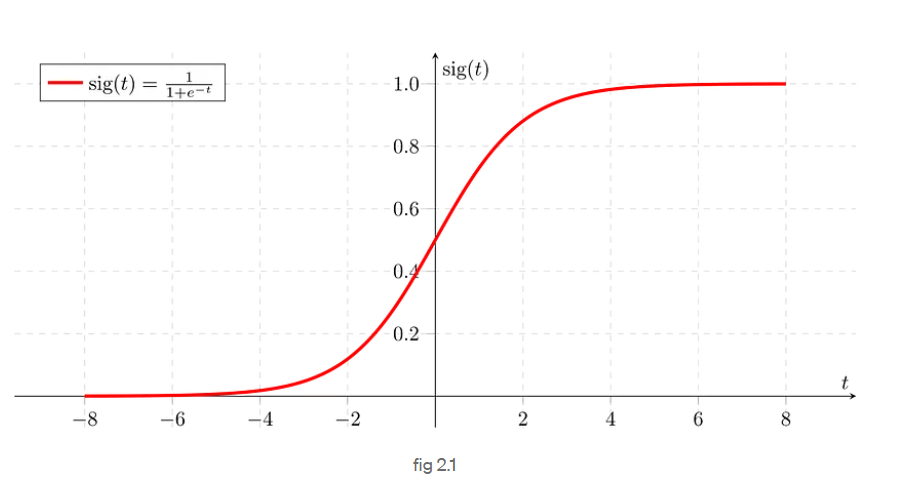

In [8]:
epsilon = 1e-10
def sigmoid(z):
    return 1 / (1 + np.exp(-z + epsilon))

<h3>Function 2: initialize_weights(num_features)</h3><br>
Description: <em>Initializes the weights and bias to zero.</em><br>


In [9]:
def initialize_weights(num_features):
    w = np.zeros(num_features)
    b = 0
    return w, b

## Cost function

For logistic regression, the cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m} \sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is:

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
*  where m is the number of training examples in the data set and:
$$
\begin{align}
  f_{\mathbf{w},b}(\mathbf{x^{(i)}}) &= g(z^{(i)})\tag{3} \\
  z^{(i)} &= \mathbf{w} \cdot \mathbf{x}^{(i)}+ b\tag{4} \\
  g(z^{(i)}) &= \frac{1}{1+e^{-z^{(i)}}}\tag{5} 
\end{align}
$$

<h3>Function 3: compute_cost(X, y, w, b)</h3><br>
Description: <em>Computes the cost function, which measures how well the model predicts the target variable.</em><br>

Mathematical Explanation:<br>
<strong>J(w) = - (1/m) Σ [ y*log(h) + (1-y)*log(1-h) ]</strong>
Where:
<ul>
    <li>J(w) is the cost function.</li>
    <li>m is the number of training examples.</li>
    <li>y(i)is the true label of the i-th training example.</li>
    <li>h(i)is the predicted probability that y(i)=1</li>
    <li>The summation is taken over all training examples.</li>
    </ul>

In [10]:
def compute_cost(X, y, w, b, class_weights=None):
    m = len(y)
    z = np.dot(X, w) + b
    h = sigmoid(z)
    
    if class_weights is not None:
        cost = -(1/m) * np.sum(y*np.log(h + epsilon) * class_weights + (1-y)*np.log(1-h + epsilon))
    else:
        cost = -(1/m) * np.sum(y*np.log(h + epsilon) + (1-y)*np.log(1-h + epsilon))
        
    return cost

## Logistic Gradient Descent


$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* m is the number of training examples in the data set      
* $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target
* For a logistic regression model  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    where $g(z)$ is the sigmoid function:  
    $g(z) = \frac{1}{1+e^{-z}}$   
    
    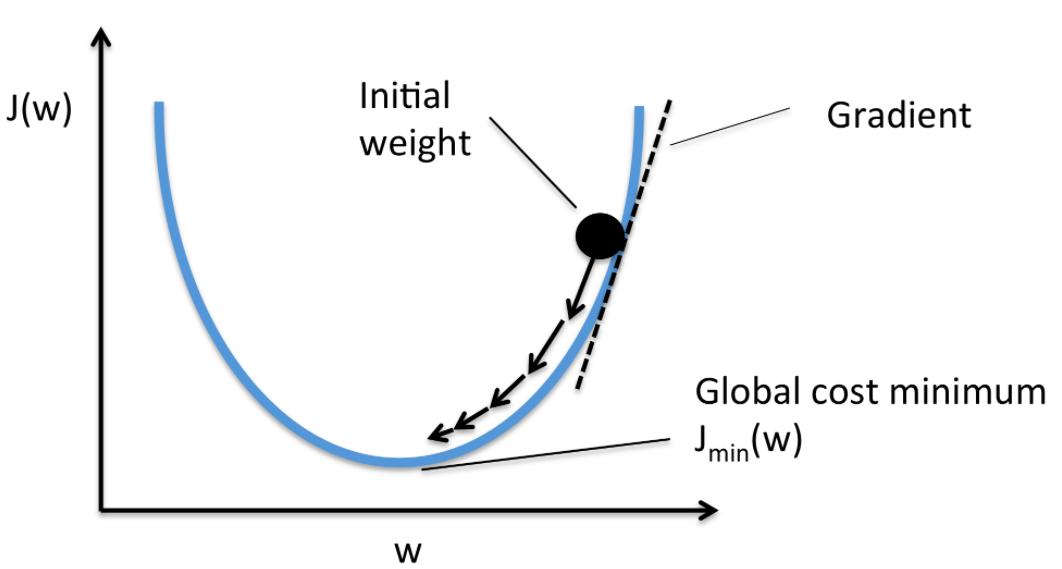

<h3>Function 4: gradient_descent(X, y, w, b, learning_rate)</h3><br>
Description: <em>Computes the cost function, which measures how well the model predicts the target variable.</em><br>

Mathematical Explanation:<br>
<strong>w_j = w_j - α * (1/m) Σ (h^(i) - y^(i)) * x_j^(i)</strong><br>

<strong>b = b - α * (1/m) Σ (h^(i) - y^(i))</strong>
Where:
<ul>
    <li>w_j represents the j-th weight.</li>
    <li>α is the learning rate.</li>
    <li>m is the number of training examples.</li>
    <li>y(i)is the true label of the i-th training example.</li>
    <li>h(i)is the predicted probability that y(i)=1</li>
    <li>x_j^(i)is the j-th feature of the i-th example.</li>
    </ul>

In [11]:
def gradient_descent(X, y, w, b, learning_rate, class_weights=None):
    m = len(y)
    z = np.dot(X, w) + b
    h = sigmoid(z)
    
    if class_weights is not None:
        dw = (1/m) * np.dot(X.T, (h - y) * class_weights[y.astype(int)])
    else:
        dw = (1/m) * np.dot(X.T, (h - y))
    
    db = (1/m) * np.sum(h - y)
    
    w = w - learning_rate * dw
    b = b - learning_rate * db
    
    return w, b

<h3>Function 5: train_logistic_regression(X, y, num_iterations, learning_rate)</h3><br>
Description: <em>Orchestrates the training process of the logistic regression model.</em><br>

In [12]:
def train_logistic_regression(X, y, num_iterations=1000, learning_rate=0.01, class_weights=None):
    w, b = initialize_weights(X.shape[1])
    costs = []  
    
    for i in range(num_iterations):
        cost = compute_cost(X, y, w, b)
        costs.append(cost) 
        
        if class_weights is not None:
            w, b = gradient_descent(X, y, w, b, learning_rate, class_weights)
        else:
            w, b = gradient_descent(X, y, w, b, learning_rate)
    
   
    plt.plot(range(num_iterations), costs)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Gradient Descent Convergence')
    plt.show()
    
    return w, b


<h2 style="color: red">Step 3: Class Weight Tuning</h2>

<h3>Function 6: compute_class_weights(y)</h3><br>
Description: <em>This function computes the class weights for handling imbalanced datasets in logistic regression.</em><br>

Mathematical Explanation:<br>
$w_j= \frac{{samples}}{samples_j * classes}$   

<strong>w_j = n_samples / ( n_samples_j * n_classes)
</strong><br>
Where:
<ul>
    <li>w_jrepresents the weight for class j</li>
    <li>n_samples is the total number of samples or rows in the dataset.</li>
    <li>n_classes is the total number of unique classes in the target variable.</li>
    <li>n_samples_j is the total number of rows belonging to class j.</li>
    </ul>
    
The class weight w_j is calculated to give more importance to the minority class during training. 

In [13]:
def compute_class_weights(y):
    n_samples = len(y)
    n_classes = len(np.unique(y))
    n_samples_j = (np.bincount(y))
    print(f"Total number of samples: {n_samples}")
    print(f"Total number of classes: {n_classes}")
    print(f"Total number of samples belonging to Non-Fraudulent : {n_samples_j[0]}")
    print(f"Total number of samples belonging to Fraudulent : {n_samples_j[1]}")
    class_weights = n_samples / (n_samples_j * n_classes )
    return class_weights

class_weights = compute_class_weights(y_train).ravel()
print(f"Class weight for non fraudulent is {class_weights[0]}")
print(f"Class weight for Fraudulent is {class_weights[1]}")

Total number of samples: 226980
Total number of classes: 2
Total number of samples belonging to Non-Fraudulent : 226597
Total number of samples belonging to Fraudulent : 383
Class weight for non fraudulent is 0.5008451126890471
Class weight for Fraudulent is 296.31853785900785


<h2 style="color: red">Step 4: Train the Logistic Regression Model</h2>

<p>Now, we'll train the logistic regression model both without and with class weight tuning.</p>

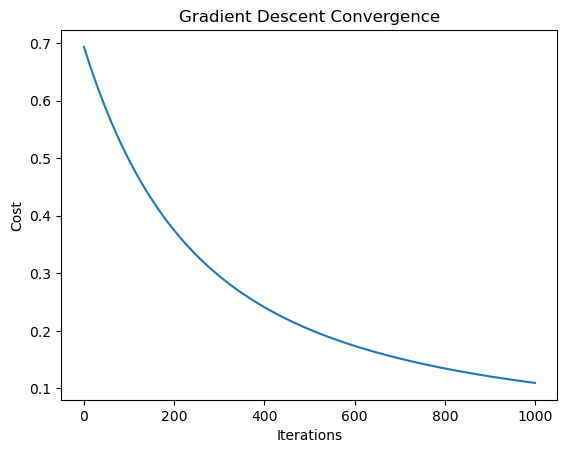

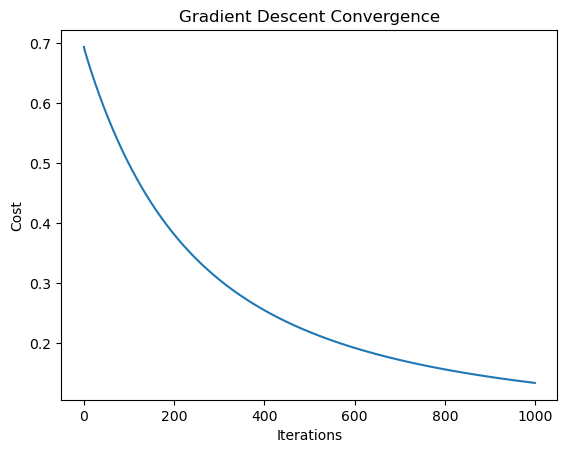

In [14]:
w_no_weights, b_no_weights = train_logistic_regression(X_train, y_train, num_iterations=1000, learning_rate=0.01)
w_with_weights, b_with_weights = train_logistic_regression(X_train, y_train, num_iterations=1000, learning_rate=0.01, class_weights=class_weights)

<h2 style="color: red">Step 5: Evaluate Model Performance</h2>

  $$f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) \tag{1}$$

  where $g(z)$ is known as the sigmoid function and it maps all input values to values between 0 and 1:

  $g(z) = \frac{1}{1+e^{-z}}\tag{2}$
  and $\mathbf{w} \cdot \mathbf{x}$ is the vector dot product:
  
  $$\mathbf{w} \cdot \mathbf{x} = w_0 x_0 + w_1 x_1$$
  
  
 * We interpret the output of the model ($f_{\mathbf{w},b}(x)$) as the probability that $y=1$ given $\mathbf{x}$ and parameterized by $\mathbf{w}$ and $b$.
* Therefore, to get a final prediction ($y=0$ or $y=1$) from the logistic regression model, we can use the following heuristic -

  if $f_{\mathbf{w},b}(x) >= 0.5$, predict $y=1$
  
  if $f_{\mathbf{w},b}(x) < 0.5$, predict $y=0$
  

In [7]:
def displayResult(X, y, w, b): 
    z = np.dot(X, w) + b
    h = sigmoid(z)
    y_pred = (h > 0.5).astype(int)
    return y_pred

In [ ]:
result_no_weights = evaluate_model(X_test, y_test, w_no_weights, b_no_weights)
result_with_weights = evaluate_model(X_test, y_test, w_with_weights, b_with_weights)
print(result)

In [16]:
def evaluate_model(X, y, w, b):
    z = np.dot(X, w) + b
    h = sigmoid(z)
    y_pred = (h > 0.5).astype(int)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, h)
    mcc = matthews_corrcoef(y, y_pred)

    return accuracy, precision, recall, f1, roc_auc,mcc


<h2 style="color: red">Step 6: Visualize Results</h2>

In [17]:
from tabulate import tabulate

metrics_no_weights = evaluate_model(X_test, y_test, w_no_weights, b_no_weights)
metrics_with_weights = evaluate_model(X_test, y_test, w_with_weights, b_with_weights)


headers = ["Metric", "Without Weights", "With Weights"]
metrics = [
    ["Accuracy", metrics_no_weights[0], metrics_with_weights[0]],
    ["Precision", metrics_no_weights[1], metrics_with_weights[1]],
    ["Recall", metrics_no_weights[2], metrics_with_weights[2]],
    ["F1 Score", metrics_no_weights[3], metrics_with_weights[3]],
    ["ROC AUC", metrics_no_weights[4], metrics_with_weights[4]],
    ["MCC", metrics_no_weights[5], metrics_with_weights[5]]
]


table = tabulate(metrics, headers, tablefmt="pretty")

print(table)

+-----------+--------------------+---------------------+
|  Metric   |  Without Weights   |    With Weights     |
+-----------+--------------------+---------------------+
| Accuracy  | 0.9989602791386177 | 0.9843160751418603  |
| Precision | 0.8780487804878049 | 0.07983193277310924 |
|  Recall   |        0.4         | 0.8444444444444444  |
| F1 Score  | 0.549618320610687  | 0.14587332053742802 |
|  ROC AUC  | 0.973076696789984  | 0.9755457890112649  |
|    MCC    | 0.592250950162399  | 0.2568487515094521  |
+-----------+--------------------+---------------------+


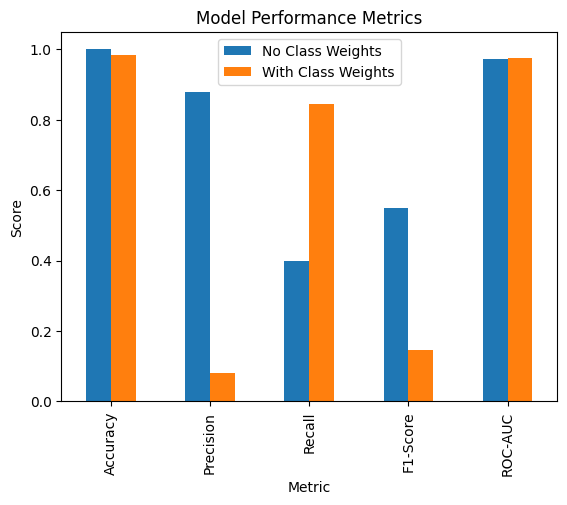

In [18]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'No Class Weights': [ metrics_no_weights[0],  metrics_no_weights[1],  metrics_no_weights[2],  metrics_no_weights[3],  metrics_no_weights[4]],
    'With Class Weights': [metrics_with_weights[0], metrics_with_weights[1], metrics_with_weights[2], metrics_with_weights[3], metrics_with_weights[4]]
})
metrics_df.plot(x='Metric', kind='bar')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()